Machine Learning Exam

This is a binary classification task with known labels.
The two different machine learning models chosen are Support Vector Machine (SVM) and Random forest

Firstly, the libraries are imported

In [165]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, cross_val_score, KFold, GridSearchCV, StratifiedKFold
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import (
    accuracy_score,
    precision_score,
    recall_score,
    f1_score,
    roc_auc_score,
    confusion_matrix,
    precision_recall_curve
)
from sklearn.svm import SVC
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.tree import DecisionTreeClassifier
from sklearn.pipeline import make_pipeline

The dataset is loaded

In [166]:

data = pd.read_csv('C:/Users/User/Documents/GitHub/ML_exam/ai4i2020.csv')

# Showing the features of the dataset here
print(data.head())

   UDI Product ID Type  Air temperature [K]  Process temperature [K]  \
0    1     M14860    M                298.1                    308.6   
1    2     L47181    L                298.2                    308.7   
2    3     L47182    L                298.1                    308.5   
3    4     L47183    L                298.2                    308.6   
4    5     L47184    L                298.2                    308.7   

   Rotational speed [rpm]  Torque [Nm]  Tool wear [min]  Machine failure  TWF  \
0                    1551         42.8                0                0    0   
1                    1408         46.3                3                0    0   
2                    1498         49.4                5                0    0   
3                    1433         39.5                7                0    0   
4                    1408         40.0                9                0    0   

   HDF  PWF  OSF  RNF  
0    0    0    0    0  
1    0    0    0    0  
2    0  

Now checking if some values are missing in the dataset and preprocessing the data. The irrelevant features are being dropped.

The dataset is also checked for imbalance

In [167]:
# Check if there are missing values in the dataset
if data.isnull().values.any():
    print("Missing values found")
else:
    print("No missing values found")

# Preprocess the data
X = data.drop(columns=['UDI', 'Product ID', 'Type', 'Machine failure', 'PWF', 'TWF', 'HDF', 'OSF', 'RNF'])
y = data['Machine failure']

#Checking if the data is balanced or not
class_distribution = y.value_counts()
print("Class distribution: ",class_distribution)


No missing values found
Class distribution:  Machine failure
0    9661
1     339
Name: count, dtype: int64


There is imbalance in the dataset because over 96% are zeros (not a failure)

Now the dataset is split into training and testing. Here 80% are chosen for training and 20% for testing. Stratify is used because of the imbalance in the dataset.

Furthermore, some information about the data is being displayed to see if there is large variance

In [168]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)
print(X.describe())

       Air temperature [K]  Process temperature [K]  Rotational speed [rpm]  \
count         10000.000000             10000.000000            10000.000000   
mean            300.004930               310.005560             1538.776100   
std               2.000259                 1.483734              179.284096   
min             295.300000               305.700000             1168.000000   
25%             298.300000               308.800000             1423.000000   
50%             300.100000               310.100000             1503.000000   
75%             301.500000               311.100000             1612.000000   
max             304.500000               313.800000             2886.000000   

        Torque [Nm]  Tool wear [min]  
count  10000.000000     10000.000000  
mean      39.986910       107.951000  
std        9.968934        63.654147  
min        3.800000         0.000000  
25%       33.200000        53.000000  
50%       40.100000       108.000000  
75%       46.80

There is a large difference between min and max in some of the features. Standardizing the features are therefore necessary.

In [169]:
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

Initializing the SVM classifier using both linear, rbf and poly kernels to see which one is best

In [170]:
linear_svm = SVC(kernel='linear')
rbf_svm = SVC(kernel='rbf')
poly_svm = SVC(kernel='poly')

Performing k-fold cross-validation with 5 folds

In [171]:
k = 5 
kf = KFold(n_splits=k, shuffle=True, random_state=42)
skf = StratifiedKFold(n_splits=k, shuffle=True, random_state=42)

Now performing cross-validation for each of the three kernels and displaying the scores

In [172]:
# Cross-validation for linear kernel
linear_cv_scores = cross_val_score(linear_svm, X_train, y_train, cv=kf)
print(f"Linear Kernel - Cross-validation scores: {linear_cv_scores}")
print(f"Linear Kernel - Mean cross-validation score: {linear_cv_scores.mean()}")

# Cross-validation for RBF kernel
rbf_cv_scores = cross_val_score(rbf_svm, X_train, y_train, cv=kf)
print(f"RBF Kernel - Cross-validation scores: {rbf_cv_scores}")
print(f"RBF Kernel - Mean cross-validation score: {rbf_cv_scores.mean()}")

# Cross-validation for POLY kernel
poly_cv_scores = cross_val_score(poly_svm, X_train, y_train, cv=kf)
print(f"POLY Kernel - Cross-validation scores: {poly_cv_scores}")
print(f"POLY Kernel - Mean cross-validation score: {poly_cv_scores.mean()}")

Linear Kernel - Cross-validation scores: [0.975    0.971875 0.9675   0.9575   0.95875 ]
Linear Kernel - Mean cross-validation score: 0.9661249999999999
RBF Kernel - Cross-validation scores: [0.9775  0.97875 0.97125 0.96625 0.9675 ]
RBF Kernel - Mean cross-validation score: 0.9722500000000001
POLY Kernel - Cross-validation scores: [0.97625  0.979375 0.971875 0.969375 0.969375]
POLY Kernel - Mean cross-validation score: 0.97325


As seen, the mean score is the best on POLY kernel but only 0,001 better than RBF kernel which is virtually nothing. The RBF kernel is slightly better than the linear. To verify which one is the best a gridsearch is being performed on all three kernels. 

Making gridsearch on all three kernels and found the rbf mean cross-validation score to be better than linear and approx. the same as poly. 
The strategy with an SVM is to try different kernels with different parameter values.
The rbf kernel is more computationally heavy than linear but less than poly.

In [173]:

pipe = make_pipeline(scaler, rbf_svm)
grid = {
    'svc__C': [0.1, 1, 10, 100],
    'svc__gamma': [0.01, 0.25, 0.5, 0.75, 1.0]
}

grid_search = GridSearchCV(estimator=pipe, param_grid=grid, cv=kf, verbose=2)
grid_search.fit(X, y) # Train the model with different parameters
grid_search.best_score_

Fitting 5 folds for each of 20 candidates, totalling 100 fits
[CV] END ........................svc__C=0.1, svc__gamma=0.01; total time=   0.1s
[CV] END ........................svc__C=0.1, svc__gamma=0.01; total time=   0.1s
[CV] END ........................svc__C=0.1, svc__gamma=0.01; total time=   0.1s
[CV] END ........................svc__C=0.1, svc__gamma=0.01; total time=   0.1s
[CV] END ........................svc__C=0.1, svc__gamma=0.01; total time=   0.1s
[CV] END ........................svc__C=0.1, svc__gamma=0.25; total time=   0.1s
[CV] END ........................svc__C=0.1, svc__gamma=0.25; total time=   0.1s
[CV] END ........................svc__C=0.1, svc__gamma=0.25; total time=   0.1s
[CV] END ........................svc__C=0.1, svc__gamma=0.25; total time=   0.1s
[CV] END ........................svc__C=0.1, svc__gamma=0.25; total time=   0.1s
[CV] END .........................svc__C=0.1, svc__gamma=0.5; total time=   0.2s
[CV] END .........................svc__C=0.1, s

0.9808

The best score for RBF kernel is 0,98

In [174]:
grid_search.best_params_

{'svc__C': 100, 'svc__gamma': 0.25}

The best parameters are tested with the rbf kernel to be C=100 and gamma = 0.25.
Now training the SVM with the rbf kernel with the best parameters on the entire dataset and evaluating it on the test set.

In [175]:
rbf_svm = SVC(kernel='rbf', C=100, gamma=0.25)
rbf_svm.fit(X_train, y_train)

SVC(C=100, gamma=0.25)

Now for the prediction

In [176]:
y_pred = rbf_svm.predict(X_test)

And the evaluation

In [177]:
def evaluate_model(y_test, y_pred):
    metrics = {
        "Accuracy": accuracy_score(y_test, y_pred),
        "Precision": precision_score(y_test, y_pred),
        "Recall": recall_score(y_test, y_pred),
        "F1 Score": f1_score(y_test, y_pred),
        "ROC AUC": roc_auc_score(y_test, y_pred),
    }
    return metrics

metrics = evaluate_model(y_test, y_pred)
print(metrics)

{'Accuracy': 0.983, 'Precision': 0.8148148148148148, 'Recall': 0.6470588235294118, 'F1 Score': 0.7213114754098361, 'ROC AUC': 0.8209414200462793}


The accuracy is 98% which is really good. The recall however is only 64,7% which is not so good. A low recall score indicates that the model is bad at identifying all the true positives in the dataset.

To showcase this, the confusion matrix is made

Confusion Matrix:
[[1922   10]
 [  24   44]]


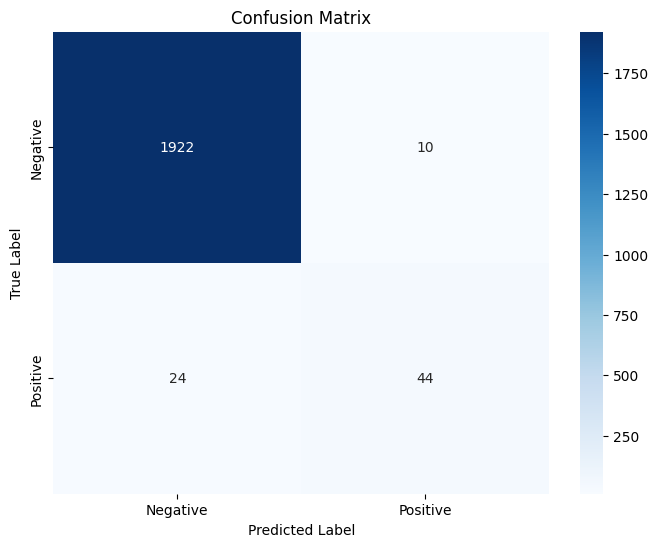

In [178]:
conf_matrix = confusion_matrix(y_test, y_pred)
print("Confusion Matrix:")
print(conf_matrix)
# Visualization function
def plot_confusion_matrix(conf_matrix, labels=['Negative', 'Positive']):
    plt.figure(figsize=(8, 6))
    sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues',
                xticklabels=labels, yticklabels=labels)
    plt.title('Confusion Matrix')
    plt.ylabel('True Label')
    plt.xlabel('Predicted Label')
    plt.show()

# Visualize the confusion matrix
plot_confusion_matrix(conf_matrix)

A normalized confusion matrix can make it easier to see

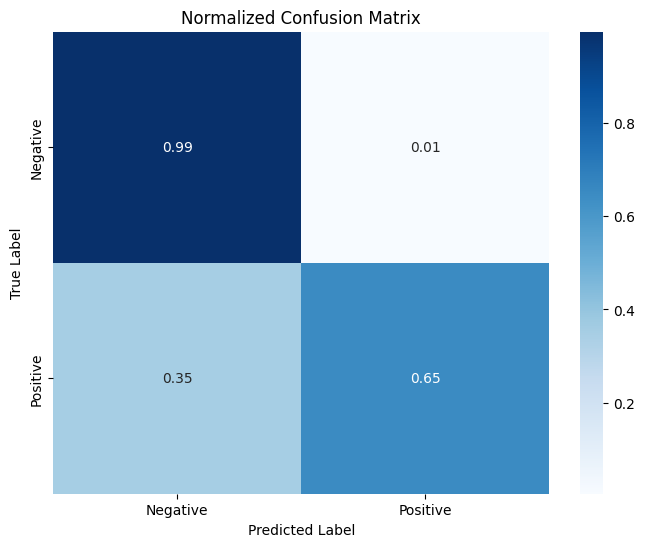

In [179]:
# Create a normalized confusion matrix visualization
cm_normalized = conf_matrix.astype('float') / conf_matrix.sum(axis=1)[:, np.newaxis]

plt.figure(figsize=(8, 6))
sns.heatmap(cm_normalized, annot=True, fmt='.2f', cmap='Blues',
            xticklabels=['Negative', 'Positive'],
            yticklabels=['Negative', 'Positive'])
plt.title('Normalized Confusion Matrix')
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.show()

As seen in the confusion matrix, 35% of the predicted negatives are actually positive, which is not preferrable when dealing with failure. However, the model is really good at predicting true negatives.

The model is improved by weighting the classes.

{'Accuracy': 0.9535, 'Precision': 0.41134751773049644, 'Recall': 0.8529411764705882, 'F1 Score': 0.5550239234449761, 'ROC AUC': 0.9049902569723542}


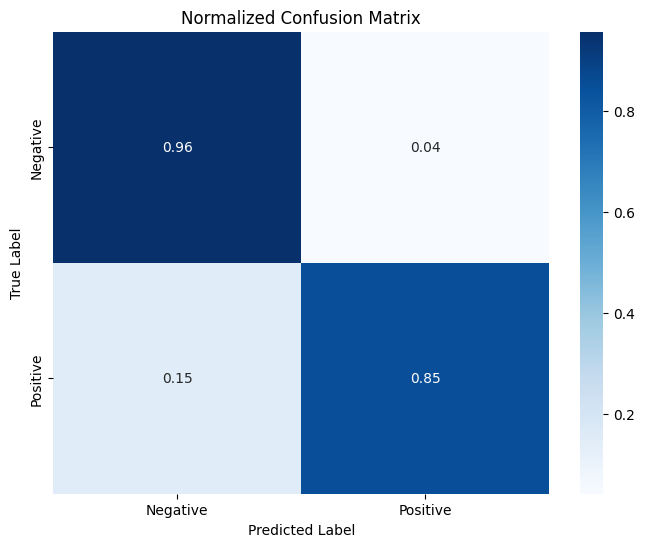

In [180]:
# Train the model with the best parameters and class weights
rbf_svm = SVC(kernel='rbf', C=100, gamma=0.25, class_weight='balanced')
rbf_svm.fit(X_train, y_train)

# Predict the test set
y_pred_weight = rbf_svm.predict(X_test)

# Calculate the metrics
metrics = evaluate_model(y_test, y_pred_weight)
print(metrics)

# Create a normalized confusion matrix visualization
conf_matrix = confusion_matrix(y_test, y_pred_weight)
cm_normalized = conf_matrix.astype('float') / conf_matrix.sum(axis=1)[:, np.newaxis]

plt.figure(figsize=(8, 6))
sns.heatmap(cm_normalized, annot=True, fmt='.2f', cmap='Blues',
            xticklabels=['Negative', 'Positive'],
            yticklabels=['Negative', 'Positive'])
plt.title('Normalized Confusion Matrix')
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.show()


The recall is improved from 65% to 85% which is a substantial improvement. The number of false negatives has fallen to 15% which is good. 

The next model implemented is Random Forest with bagging and feature randomness. When choosing feature randomness, the accuracy for predicting positives are better but the accuracy for detecting negatives are slightly better without feature randomness.

100 trees are chosen

In [181]:
rf_model = RandomForestClassifier(n_estimators=100, random_state=42)

Training the model

In [182]:

rf_model.fit(X_train, y_train)

RandomForestClassifier(random_state=42)

Predictions

In [183]:
y_pred_rf = rf_model.predict(X_test)
y_pred_prob_rf = rf_model.predict_proba(X_test)[:, 1]

Evaluating the Random Forest model (accuracy, precision, recall, f1-score, ROC-AUC)

In [184]:
metrics = evaluate_model(y_test, y_pred_rf)
print(metrics)

{'Accuracy': 0.985, 'Precision': 0.8958333333333334, 'Recall': 0.6323529411764706, 'F1 Score': 0.7413793103448276, 'ROC AUC': 0.814882474729022}


The model overall scores high in accuracy, precision and ROC-AUC. The recall however is low. 

Now making a normalized confusion matrix

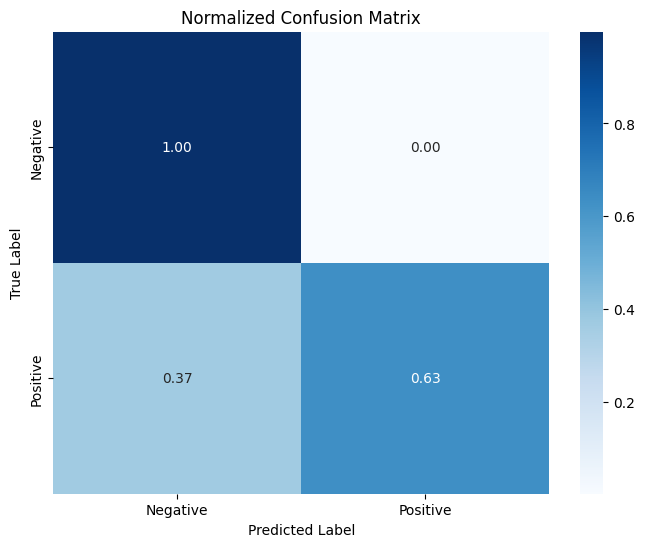

In [185]:
conf_matrix_rf = confusion_matrix(y_test, y_pred_rf)
cm_normalized = conf_matrix_rf.astype('float') / conf_matrix_rf.sum(axis=1)[:, np.newaxis]

plt.figure(figsize=(8, 6))
sns.heatmap(cm_normalized, annot=True, fmt='.2f', cmap='Blues',
            xticklabels=['Negative', 'Positive'],
            yticklabels=['Negative', 'Positive'])
plt.title('Normalized Confusion Matrix')
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.show()

As seen in the normalized confusion matrix, the model predicts 63% of the positives correctly. This could be higher, if the threshold was to be lowered. 

Making a PR curve to show the tradeoff between precision (positive predictive value) and recall (sensitivity) for different threshold values.
The PR curve is particularly useful for evaluating models on imbalanced datasets, where precision and recall offer more insight than the overall accuracy metric. Higher area under curve = better model

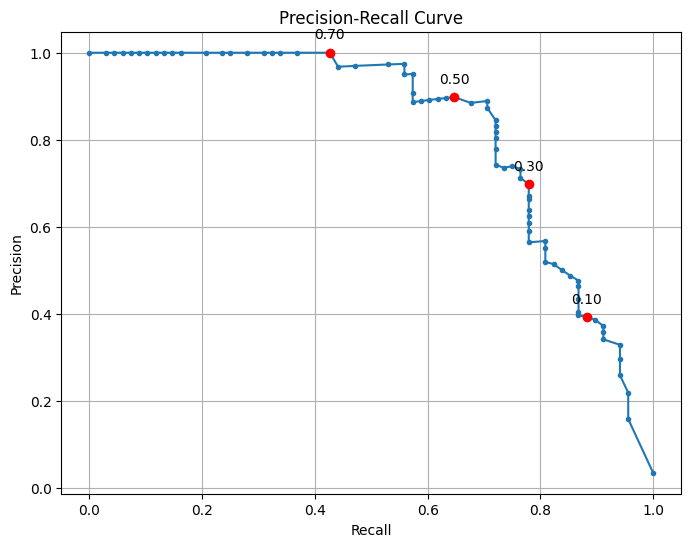

In [186]:
precision, recall, thresholds = precision_recall_curve(y_test, y_pred_prob_rf)

relevant_thresholds = [0.1, 0.3, 0.5, 0.7]

plt.figure(figsize=(8, 6))
plt.plot(recall, precision, marker='.')
plt.title('Precision-Recall Curve')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.grid(True)

for threshold in relevant_thresholds:
    idx = np.argmin(np.abs(thresholds - threshold))
    plt.annotate(f'{threshold:.2f}', (recall[idx], precision[idx]), textcoords="offset points", xytext=(0,10), ha='center')
    plt.plot(recall[idx], precision[idx], 'ro') 
plt.show()


As seen in the PR curve, the area under the curve is large meaning that the model is good

Lower threshold = catch more machine failures but are more sensitive to catch false alerts too.
Higher threshold = fewer false alerts but might miss some machine failures

Testing to see what the effects of lowering the threshold will be.

Recall: 0.8676470588235294


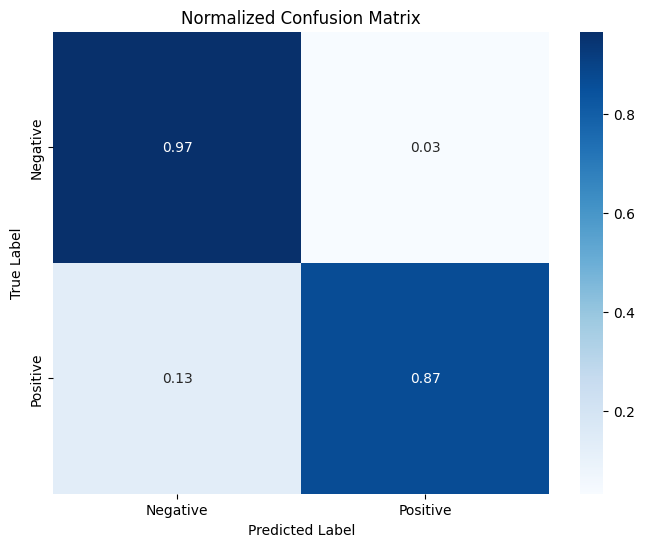

In [187]:
y_prob_thres = rf_model.predict_proba(X_test)[:, 1]
threshold = 0.15  # Lower threshold to improve recall
y_pred_thres = (y_prob_thres >= threshold).astype(int)
recall = recall_score(y_test, y_pred_thres)
print(f"Recall: {recall}")

# Create a normalized confusion matrix visualization
conf_matrix = confusion_matrix(y_test, y_pred_thres)

cm_normalized = conf_matrix.astype('float') / conf_matrix.sum(axis=1)[:, np.newaxis]

plt.figure(figsize=(8, 6))
sns.heatmap(cm_normalized, annot=True, fmt='.2f', cmap='Blues',
            xticklabels=['Negative', 'Positive'],
            yticklabels=['Negative', 'Positive'])
plt.title('Normalized Confusion Matrix')
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.show()

By using the PR-curve and changing the threshold to 0.15 the recall is now 87% which means significantly fewer are predicted as false negatives. The number of false positives increased but is not deemed as critical.

Feature importance. This shows how much each feature contributes to the model's decisions

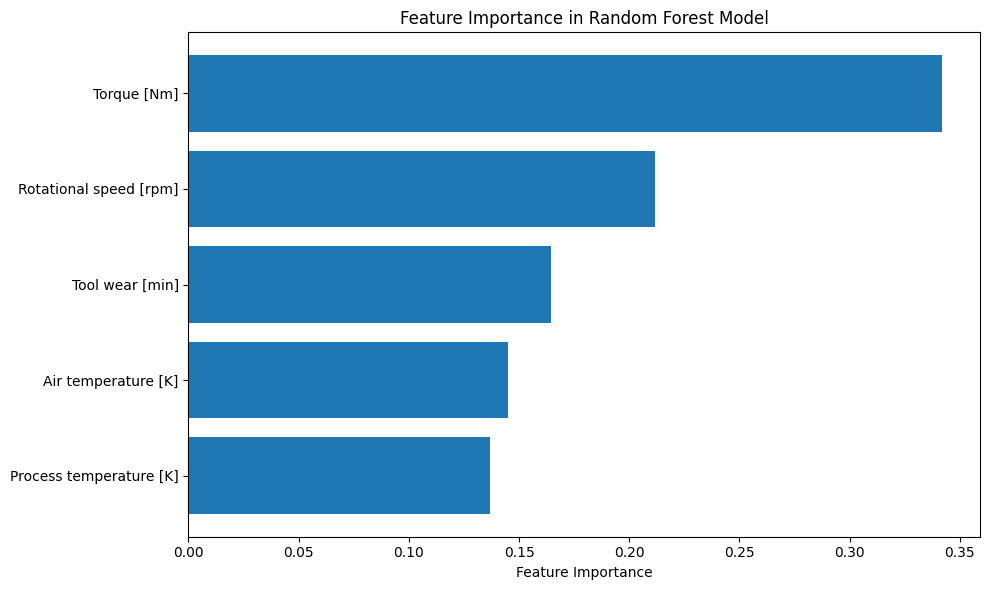

In [188]:
feature_importance = rf_model.feature_importances_
feature_names = data.drop(columns=['UDI', 'Product ID', 'Type', 'Machine failure']).columns


sorted_idx = np.argsort(feature_importance)
pos = np.arange(sorted_idx.shape[0]) + .5

# Plot feature importance
plt.figure(figsize=(10, 6))
plt.barh(pos, feature_importance[sorted_idx], align='center')
plt.yticks(pos, np.array(feature_names)[sorted_idx])
plt.xlabel('Feature Importance')
plt.title('Feature Importance in Random Forest Model')
plt.tight_layout()
plt.show()


The torque's importance is significantly higher than the rest of them.

Overall the random forest model has relatively accurate predictions and was improved by lowering the threshold. This however introduced other inaaccuracies. 

Another improvement could be to use the feature importance and enhance the most important features.